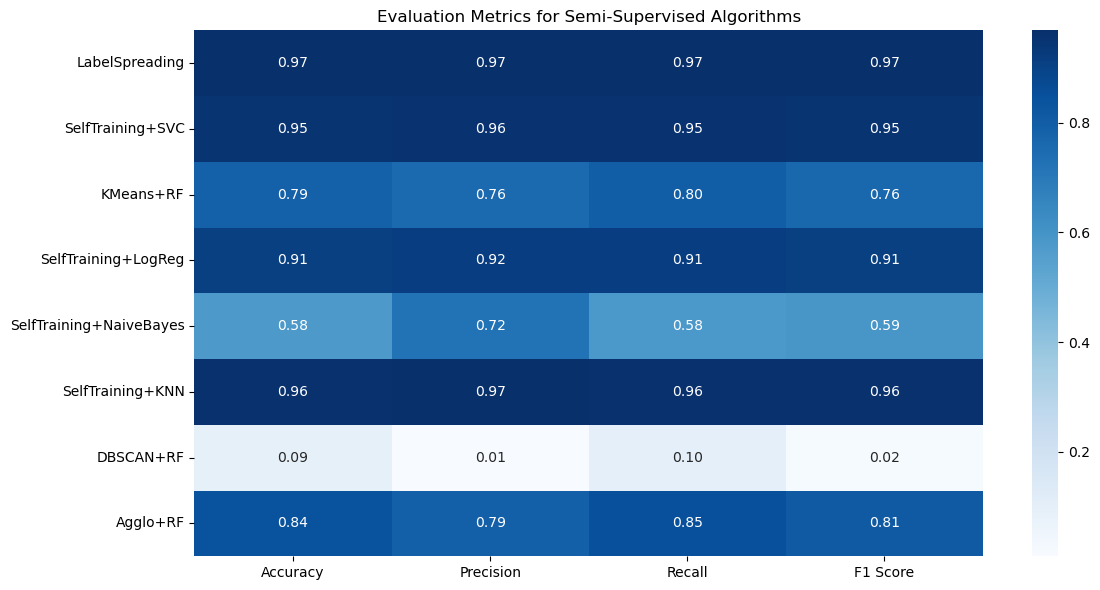

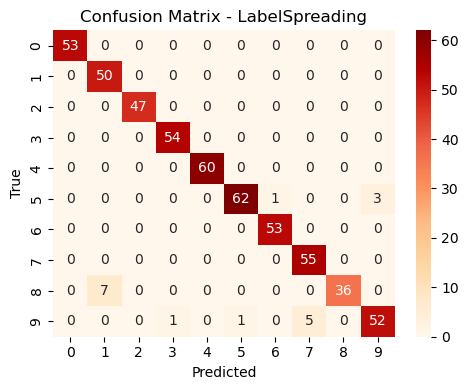

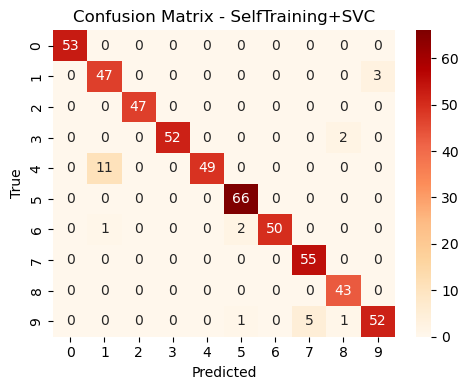

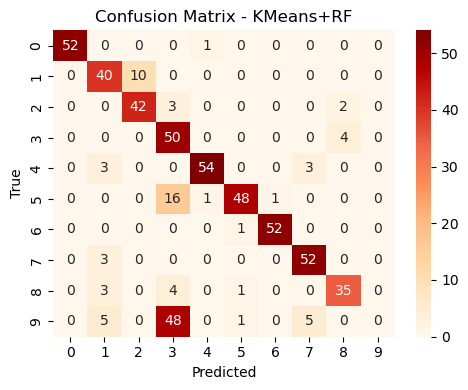

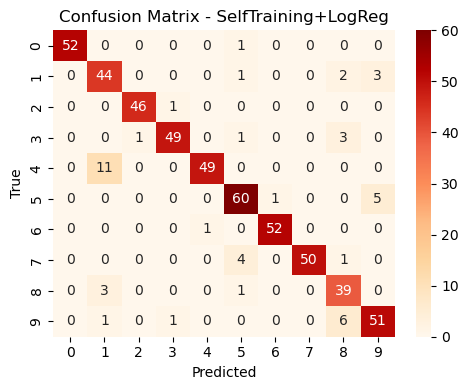

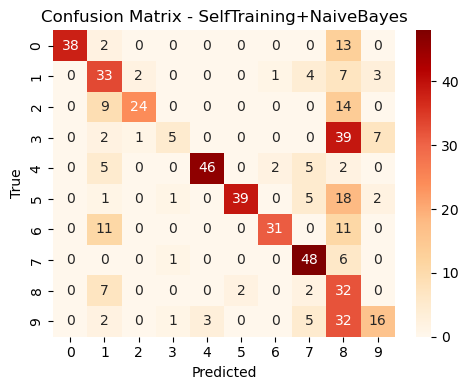

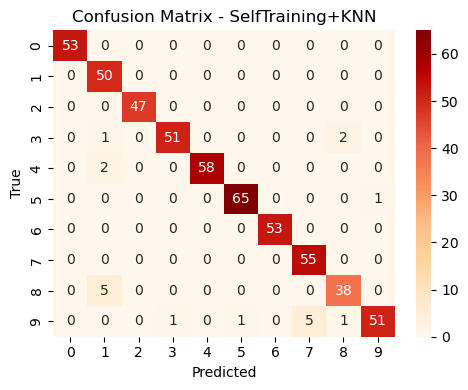

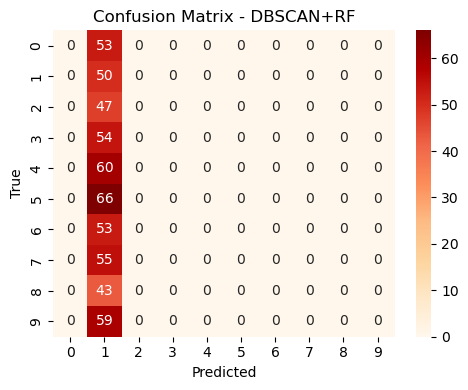

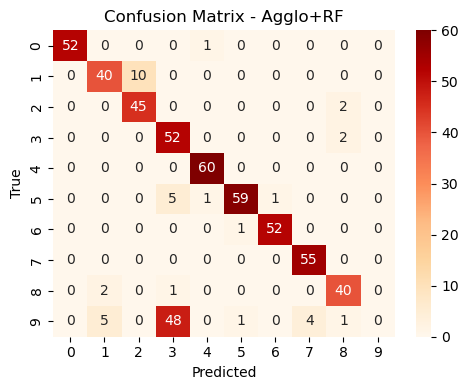

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

data = load_digits()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
n_labeled = 100
y_train_semi = np.copy(y_train)
y_train_semi[n_labeled:] = -1

results = {}
conf_matrices = {}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    conf = confusion_matrix(y_test, y_pred)
    results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}
    conf_matrices[name] = conf

label_spread = LabelSpreading(kernel='knn', n_neighbors=7)
label_spread.fit(X_train, y_train_semi)
evaluate_model("LabelSpreading", label_spread, X_test, y_test)

base_svc = SVC(probability=True)
self_train = SelfTrainingClassifier(base_svc, threshold=0.75)
self_train.fit(X_train, y_train_semi)
evaluate_model("SelfTraining+SVC", self_train, X_test, y_test)

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_train)
cluster_to_label = {}
for i in range(10):
    mask = (cluster_labels == i) & (y_train != -1)
    if np.any(mask):
        cluster_to_label[i] = np.bincount(y_train[mask]).argmax()
    else:
        cluster_to_label[i] = -1
pseudo_labels = np.array([cluster_to_label[cl] for cl in cluster_labels])
mask_valid = pseudo_labels != -1
X_pseudo = X_train[mask_valid]
y_pseudo = pseudo_labels[mask_valid]
clf_pseudo = RandomForestClassifier()
clf_pseudo.fit(X_pseudo, y_pseudo)
evaluate_model("KMeans+RF", clf_pseudo, X_test, y_test)

lr = LogisticRegression(max_iter=1000)
self_train_lr = SelfTrainingClassifier(lr, threshold=0.8)
self_train_lr.fit(X_train, y_train_semi)
evaluate_model("SelfTraining+LogReg", self_train_lr, X_test, y_test)

nb = GaussianNB()
self_train_nb = SelfTrainingClassifier(nb, threshold=0.8)
self_train_nb.fit(X_train, y_train_semi)
evaluate_model("SelfTraining+NaiveBayes", self_train_nb, X_test, y_test)

knn = KNeighborsClassifier(n_neighbors=3)
self_train_knn = SelfTrainingClassifier(knn, threshold=0.8)
self_train_knn.fit(X_train, y_train_semi)
evaluate_model("SelfTraining+KNN", self_train_knn, X_test, y_test)

dbscan = DBSCAN(eps=40, min_samples=5)
db_labels = dbscan.fit_predict(X_train)
db_label_map = {}
for lbl in np.unique(db_labels):
    if lbl == -1:
        continue
    mask = (db_labels == lbl) & (y_train != -1)
    if np.any(mask):
        db_label_map[lbl] = np.bincount(y_train[mask]).argmax()
    else:
        db_label_map[lbl] = -1
pseudo_db_labels = np.array([db_label_map.get(lbl, -1) for lbl in db_labels])
mask_valid_db = pseudo_db_labels != -1
clf_db = RandomForestClassifier()
clf_db.fit(X_train[mask_valid_db], pseudo_db_labels[mask_valid_db])
evaluate_model("DBSCAN+RF", clf_db, X_test, y_test)

agglo = AgglomerativeClustering(n_clusters=10)
agglo_labels = agglo.fit_predict(X_train)
agglo_label_map = {}
for lbl in np.unique(agglo_labels):
    mask = (agglo_labels == lbl) & (y_train != -1)
    if np.any(mask):
        agglo_label_map[lbl] = np.bincount(y_train[mask]).argmax()
    else:
        agglo_label_map[lbl] = -1
pseudo_agglo_labels = np.array([agglo_label_map.get(lbl, -1) for lbl in agglo_labels])
mask_valid_ag = pseudo_agglo_labels != -1
clf_ag = RandomForestClassifier()
clf_ag.fit(X_train[mask_valid_ag], pseudo_agglo_labels[mask_valid_ag])
evaluate_model("Agglo+RF", clf_ag, X_test, y_test)

metrics_matrix = {
    k: [v['accuracy'], v['precision'], v['recall'], v['f1']] for k, v in results.items()
}
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(12, 6))
sns.heatmap(
    data=np.array(list(metrics_matrix.values())),
    annot=True,
    fmt=".2f",
    xticklabels=metrics_names,
    yticklabels=list(metrics_matrix.keys()),
    cmap='Blues'
)
plt.title("Evaluation Metrics for Semi-Supervised Algorithms")
plt.tight_layout()
plt.show()

for name, cm in conf_matrices.items():
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
